# Image registration
To find the strain distribution over the surface of the gel, we used DIPY pakacges.
### 1. The background
In this package for 2d registration,they used Symmetric Normalization (SyN) algorithm approachestablised by Avants[Avants](https://www.sciencedirect.com/science/article/abs/pii/S1361841507000606). 

In [21]:
import cv2
import pims
import math
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import matplotlib.pyplot as plt
from skimage import draw, filters
from PIL import Image, ImageSequence
#here we import all important dipy classes we need for image registration
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import SSDMetric
from dipy.viz import regtools

### 2. Importing the file and spliting movie to images sequence
Since for images processing I need a images sequence I deside to splite my movie file to images sequences. Although I think it is not the best thing to do and i need to change it. 

## $\color{Red}{change it!}$


In [2]:
im = Image.open("test.tif")

for i, page in enumerate(ImageSequence.Iterator(im)):
    page.save("page%d.tif" % i)

### Reading the files
After spliting the movie to images sequences, not we need to read and import it to our jupyter norbook. 


In [3]:
@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel
frames = pims.open('*.tif') # all files that we need to attach them in a video series. 

### 2.Using open CV to find the 
In this approach, we need to compare two images. Therefore, we need to select a references image which will used as initial configuration of our images.

In [4]:
static =frames[130] # First frames we need to trace the particel
moving1 = frames[140] #Second frames we need to find the the path
moving2 = frames[150]
moving3 = frames[160]
moving4 = frames[170]
moving5 = frames[180]

### Comparing the reference images and the traget images in red and green and the overlap image

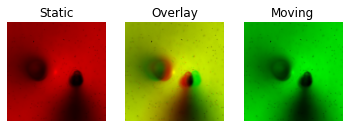

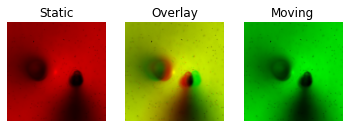

In [5]:
regtools.overlay_images(static, moving5, 'Static', 'Overlay', 'Moving','input_images.png')

## 2. Preprocessing
### 2.1 Similarity metric selection
What is he similarity metric?

A similarity metric is in charge of keeping track of the numerical value of the similarity (or distance) between the two given images. It also computes the update field for the forward and inverse displacement fields to be used in a gradient-based optimization algorithm. Note that this metric does not depend on any transformation (affine or non-linear) so it assumes the static and moving images are already warped

What kind of metric do we have in Dipy?
1. Mutual Information
2. Sum of Squared Differences

The first decision we need to make is what similarity metric is appropriate for our problem. In this example we are using two binary images, so the Sum of Squared Differences (SSD) is a good choice.

In [6]:
dim = static.ndim
metric = SSDMetric(dim)

In [7]:
level_iters = [100, 100, 50, 25]

sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter=10)


In [8]:
mapping1 = sdr.optimize(static, moving1)
mapping2 = sdr.optimize(static, moving2)
mapping3 = sdr.optimize(static, moving3)
mapping4 = sdr.optimize(static, moving4)
mapping5 = sdr.optimize(static, moving5)

In [182]:
def DISFIels(mapping,Num):
    DisfwX=[]
    DisfwY=[]
    DisbwX=[]
    DisbwY=[]
    for j in range(0,len(mapping.get_forward_field()),Num):
        lfwx=[]
        lfwy=[]
        lbwx=[]
        lbwy=[]
        for k in range(0,len(mapping.get_forward_field()[0]),Num):
            lfwx.append(mapping.get_forward_field()[j][k][0])
            lfwy.append(mapping.get_forward_field()[j][k][1])
            lbwx.append(mapping.get_backward_field()[j][k][0])
            lbwy.append(mapping.get_backward_field()[j][k][1])
        DisfwX.append(lfwx)
        DisfwY.append(lfwy)
        DisbwX.append(lbwx)
        DisbwY.append(lbwy)
    fwx = np.arange(0,len(mapping.get_forward_field()),Num)
    fwy = np.arange(0,len(mapping.get_forward_field()[0]),Num)
    bwx = np.arange(0,len(mapping.get_backward_field()),Num)
    bwy = np.arange(0,len(mapping.get_backward_field()[0]),Num)
    fwX, fwY = np.meshgrid(fwx, fwy)
    bwX, bwY = np.meshgrid(bwx, bwy)
    return fwX,fwY,DisfwX,DisfwY,bwX,bwY,DisbwX,DisbwY

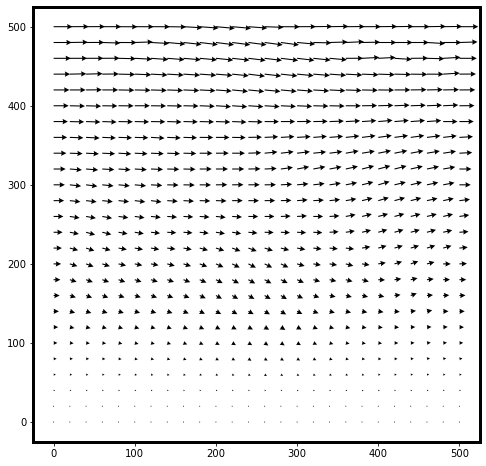

In [183]:
plt.quiver(DISFIels(mapping2,20)[1],DISFIels(mapping2,20)[0],DISFIels(mapping2,20)[4],DISFIels(mapping2,20)[3],lw=5,headwidth=5)

In [184]:
fwx = np.arange(0,len(mapping.get_forward_field()),20)
fwy = np.arange(0,len(mapping.get_forward_field()[0]),20)
bwx = np.arange(0,len(mapping.get_backward_field()),20)
bwy = np.arange(0,len(mapping.get_backward_field()[0]),20)
fwX, fwY = np.meshgrid(fwx, fwy)
bwX, bwY = np.meshgrid(bwx, bwy)

In [10]:
def overlap(img0, img1):

    # Normalize the input images to [0,255]
    img0 = 255 * ((img0 - img0.min()) / (img0.max() - img0.min()))
    img1 = 255 * ((img1 - img1.min()) / (img1.max() - img1.min()))

    # Create the color images
    img0_red = np.zeros(shape=(img0.shape) + (3,), dtype=np.uint8)
    img1_green = np.zeros(shape=(img0.shape) + (3,), dtype=np.uint8)
    overlay = np.zeros(shape=(img0.shape) + (3,), dtype=np.uint8)

    # Copy the normalized intensities into the appropriate channels of the
    # color images
    img0_red[..., 0] = img0
    img1_green[..., 1] = img1
    overlay[..., 0] = img0
    overlay[..., 1] = img1

    fig =overlay
    return fig

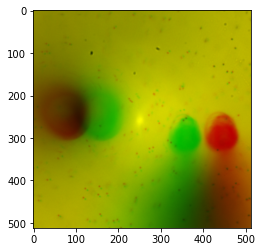

In [12]:
plt.imshow(overlap(static, moving1))

NameError: name 'fwY' is not defined

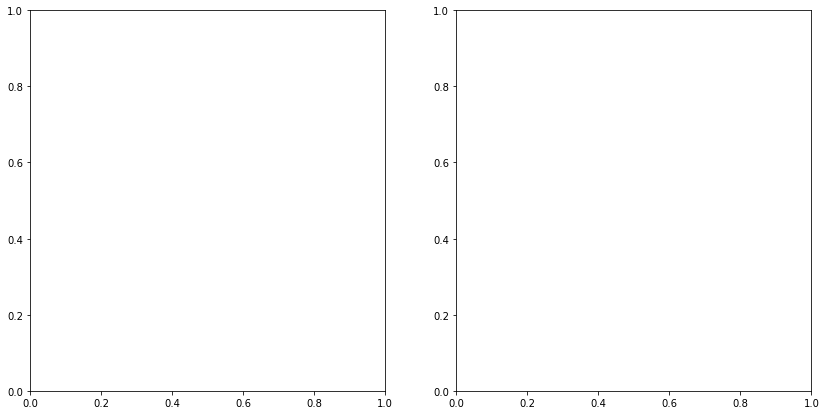

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,7))
ax1.quiver(fwY,fwX,DisfwY,DisfwX,lw=5,headwidth=5)
ax1.imshow(overlap(static, moving1))
ax2.quiver(bwY,bwX,DisbwY,DisbwX,linewidths=40,headwidth=10)

#ax.axis([-0.2, 2.3, -0.2, 2.3])
ax.set_aspect('equal')

plt.show()

ValueError: Argument U has a size 0 which does not match 676, the number of arrow positions

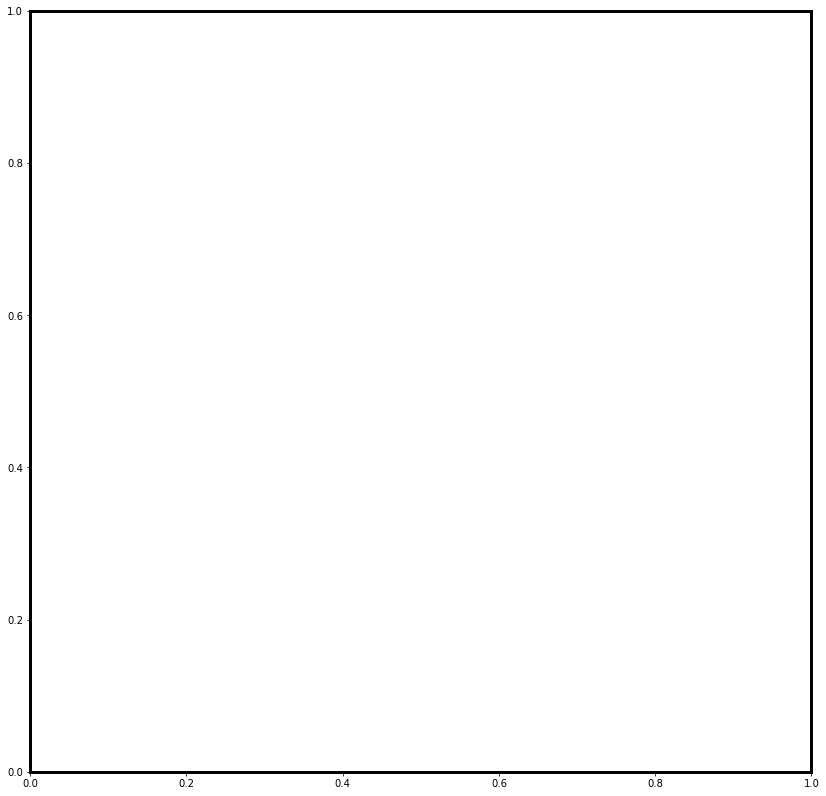

In [172]:
fig, ax1=plt.subplots(figsize=(14,14))
ax1.quiver(fwY,fwX,DisfwY,DisfwX,lw=5,headwidth=5)
ax1.imshow(overlap(static, moving1))

In [50]:
from dipy.data import get_fnames

fname_moving = get_fnames('reg_o')
fname_static = get_fnames('reg_c')

moving = np.load(fname_moving)
static = np.load(fname_static)

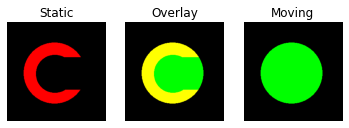

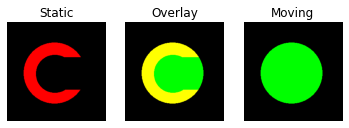

In [51]:
regtools.overlay_images(static, moving, 'Static', 'Overlay', 'Moving',
                        'input_images.png')

In [52]:
dim = static.ndim
metric = SSDMetric(dim)

In [53]:
level_iters = [200, 100, 50, 25]

sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter=50)

In [124]:
mapping = sdr.optimize(static, moving1)

KeyboardInterrupt: 

In [14]:
DisfwX5=[]
DisfwY5=[]
DisbwX5=[]
DisbwY5=[]
for j in range(0,len(mapping5.get_forward_field()),20):
    lfwx=[]
    lfwy=[]
    lbwx=[]
    lbwy=[]
    for k in range(0,len(mapping5.get_forward_field()[0]),20):
        lfwx.append(mapping5.get_forward_field()[j][k][0])
        lfwy.append(mapping5.get_forward_field()[j][k][1])
        lbwx.append(mapping5.get_backward_field()[j][k][0])
        lbwy.append(mapping5.get_backward_field()[j][k][1])
    DisfwX5.append(lfwx)
    DisfwY5.append(lfwy)
    DisbwX5.append(lbwx)
    DisbwY5.append(lbwy)

In [15]:
fwx = np.arange(0,len(mapping5.get_forward_field()),20)
fwy = np.arange(0,len(mapping5.get_forward_field()[0]),20)
bwx = np.arange(0,len(mapping5.get_backward_field()),20)
bwy = np.arange(0,len(mapping5.get_backward_field()[0]),20)
fwX, fwY = np.meshgrid(fwx, fwy)
bwX, bwY = np.meshgrid(bwx, bwy)

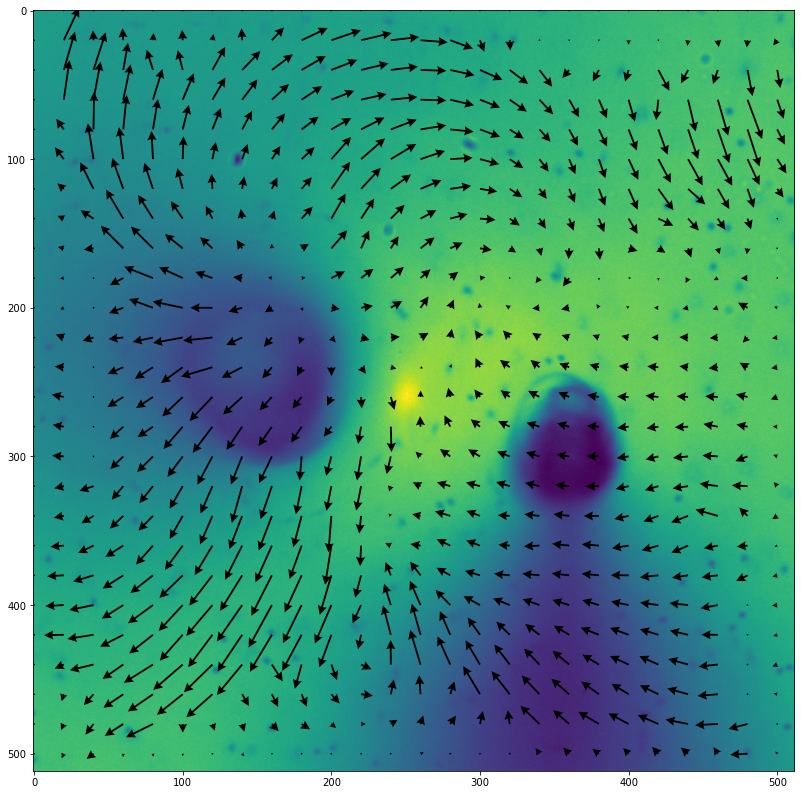

In [16]:
fig, ax1=plt.subplots(figsize=(14,14))
ax1.quiver(fwY,fwX,DisfwY5,DisfwX5,lw=5,headwidth=5)
ax1.imshow(static)

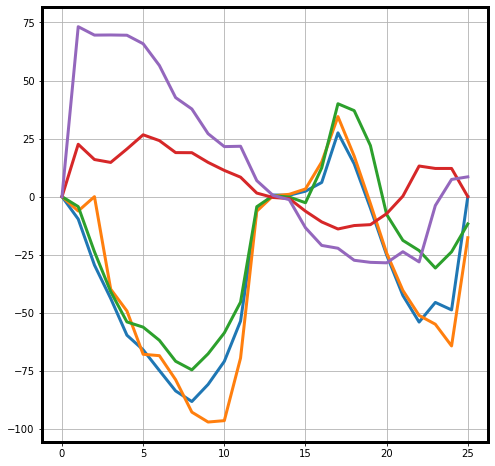

In [170]:
plt.plot(DisfwY1[13],lw=3)
plt.plot(DisfwY2[13],lw=3)
plt.plot(DisfwY3[13],lw=3)
plt.plot(DisfwY4[13],lw=3)
plt.plot(DisfwY5[13],lw=3)
plt.rcParams["figure.figsize"] = (8,8)
plt.grid()
#plt.setp(ax.spines.values(), linewidth=5)
plt.rcParams['axes.linewidth'] = 3

In [158]:
len(DisfwY)

0

In [22]:
def DIs(X,Y,E,Nu,p1,D,h):
    V=(p1/(16*math.pi(-1 + Nu) (E + Nu)))*((2 *(x1 - h)*y)/((x1 - h)^2 + y^2)^(2/2)) -(p1/(16*math.pi*(-1 + Nu)*(E + Nu)))*((2 *(x1 + h)*(y + D))/((x1 + h)^2 + (y + 1)^2)^(2/2))
    return V

In [69]:
DIs(1,3,5,5,2,1,8)

TypeError: 'float' object is not callable

In [80]:
def DIs1(x1,y,E,Nu,p1,D,h):
    V=(p1/(16*math.pi*(Nu-1)*(E + Nu)))*((2 *(x1 - h)*y)/((x1 - h)**2 + y**2)**(2/2))-(p1/(16*math.pi*(-1 + Nu)*(E + Nu)))*((2 *(x1 + h)*(y + D))/((x1 + h)**2 + (y + 1)**2)**(2/2))
    U=(p1/(16*math.pi*(-1 + Nu)*(E +Nu)))*(-(2 *(-3 + 4*Nu))*(math.log(((x1 - h)**2 + y**2)**(1/2))) + 1 - 2*(y/((x1 - h)**2 + y**2)**(1/2))**2)-(p1/(16*math.pi*(-1 + Nu)*(E +Nu)))*(-(2 *(-3 + 4*Nu))*(math.log(((x1 - h)**2 + y**2)**(1/2))) + 1 - 2*(y/((x1 - h)**2 + y**2)**(1/2))**2)
    return V,U

In [81]:
DIs1(1,3,5,5,2,1,8)

(-0.0014586609941656334, 0.0)

In [76]:
def DIs2(x1,y,E,Nu,p1,D,h):
    u=np.zeros(len(x1))
    u=(p1/(16*math.pi*(-1 + Nu)*(E +Nu)))*(-(2 *(-3 + 4*Nu))*(math.log(((x1 - h)**2 + y**2)**(1/2))) + 1 - 2*(y/((x1 - h)**2 + y**2)**(1/2))**2)
    return u

In [77]:
DIs2(1,3,5,5,2,1,8)

-0.06797694229309527

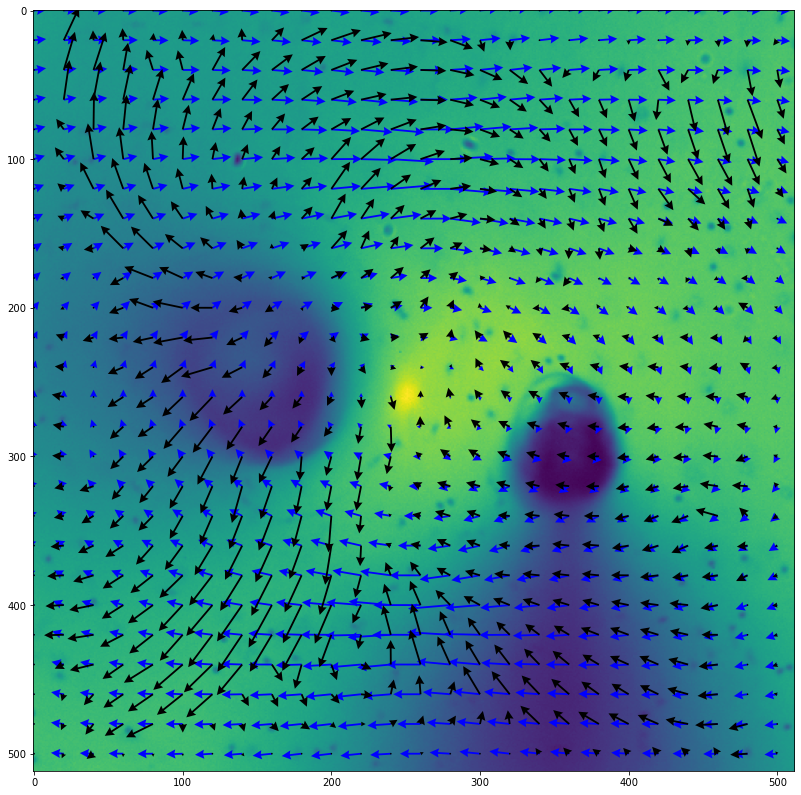

In [221]:
p1=50
E=700
Nu=0.3
h=150
D=50
x1=fwX-260
y=fwY-260

V=(p1/(16*math.pi*(Nu-1)*(E + Nu)))*((2 *(x1 + h)*y)/((x1 + h)**2 + y**2))-(p1/(16*math.pi*(Nu-1)*(E + Nu)))*((2 *(x1 - h)*y)/((x1 - h)**2 + y**2))
U=(p1/(16*math.pi*(-1 + Nu)*(E +Nu)))*(-(2 *(-3 + 4*Nu))*(np.log(((x1 + h)**2 + y**2)**(1/2))) + 1 - 2*(y/((x1 + h)**2 + y**2)**(1/2))**2)-(p1/(16*np.pi*(-1 + Nu)*(E +Nu)))*(-(2 *(-3 + 4*Nu))*(np.log(((x1 - h)**2 + y**2)**(1/2))) + 1 - 2*(y/((x1 - h)**2 + y**2)**(1/2))**2)
fig, ax1=plt.subplots(figsize=(14,14))
ax1.quiver(fwY,fwX,U,V,lw=5,headwidth=5,color='b')
ax1.quiver(fwY,fwX,DisfwY5,DisfwX5,lw=5,headwidth=5)
ax1.imshow(static)

In [202]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [110]:
DIs2(x,y,40,0.4,20,1,0)

TypeError: only size-1 arrays can be converted to Python scalars

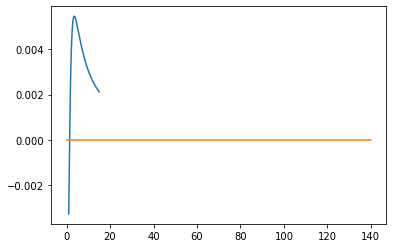

In [111]:
f2 = np.vectorize(DIs1)
x = np.arange(1, 15.1, 0.1)
plt.plot(x, f2(x,1,40,0.4,20,1,0)[0],f2(x,1,40,0.4,20,1,0)[1])
plt.show()

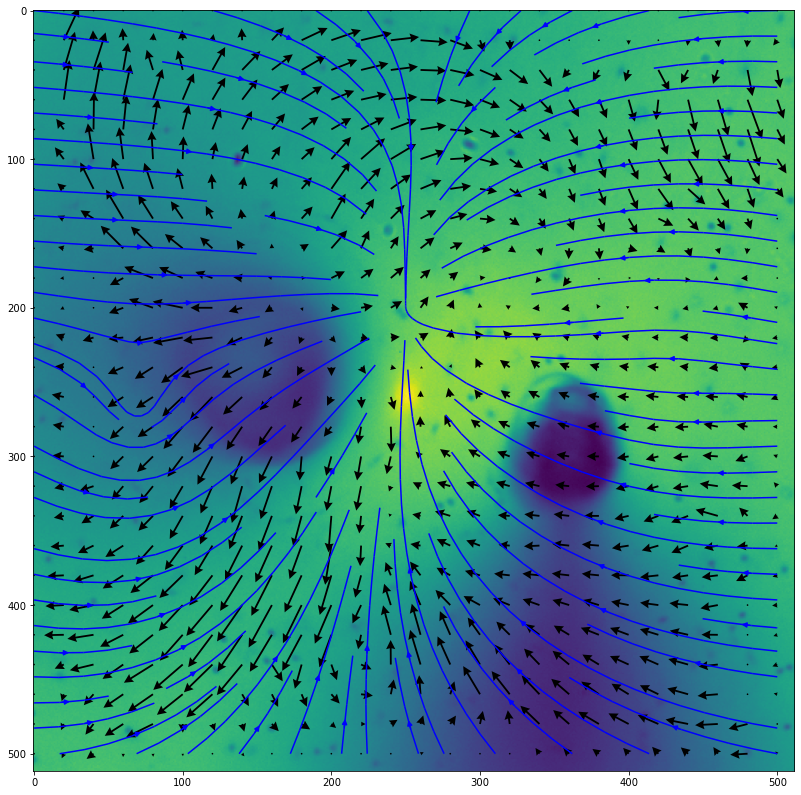

In [194]:
x = np.linspace(0, 500, 26)
y = np.linspace(0, 500, 26)
X, Y = np.meshgrid(x, y)
D=100
x1=X-250
y=Y-250
U =(p1/(16*math.pi*(Nu-1)*(E + Nu)))*((2 *(x1 + h)*(y+D))/((x1 + h)**2 + y**2)**(2/2))-(p1/(16*math.pi*(Nu-1)*(E + Nu)))*((2 *(x1 - h)*y)/((x1 - h)**2 + y**2)**(2/2))
V = (p1/(16*math.pi*(-1 + Nu)*(E +Nu)))*(-(2 *(-3 + 4*Nu))*(np.log(((x1 + h)**2 + (y+D)**2)**(1/2))) + 1 - 2*((y+D)/((x1 + h)**2 + (y+D)**2)**(1/2))**2)-(p1/(16*math.pi*(-1 + Nu)*(E +Nu)))*(-(2 *(-3 + 4*Nu))*(np.log(((x1 - h)**2 + y**2)**(1/2))) + 1 - 2*(y/((x1 - h)**2 + y**2)**(1/2))**2)
fig, ax1=plt.subplots(figsize=(14,14))

ax1.streamplot(X, Y, V, U,color="b")
ax1.quiver(fwY,fwX,DisfwY5,DisfwX5,lw=5,headwidth=5)
ax1.imshow(static)
plt.show()

In [182]:
len(fwY)

26